# Python implementation

We'll now implement Lukas-Kanade Tracker (KLT) from scratch on our own. We'll first load an image and transform it using different transformation functions. We0ll then implement KLT to recover the transformations. 

To warp a given image I(x,y), we apply I(W(x,y,p)) with the warp W and parameters p. The warp matrix W is a 2x3 matrix of 6 parameters, so we can do affine warps only. 

We first write a function that, given input translations x,y and rotation a, returns us the corresponding Warp matrix. We will then write a second function that, given an image and a Warp matrix, returns a warped image for us. 

Populating the interactive namespace from numpy and matplotlib


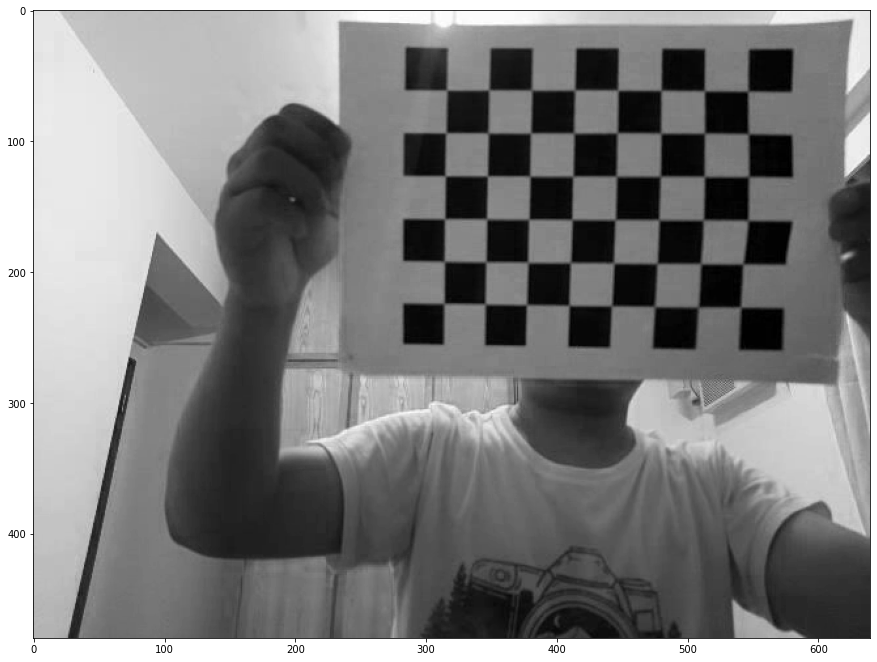

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 15)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Example image (since we have a greyscale image, reduce dimensionality down to 2)
img = mpimg.imread('image/Feature-Tracking/570.png')[:,:,0] 
img = np.array(img, dtype=np.float32) / 255
plt.imshow(img, cmap='gray')
plt.show()

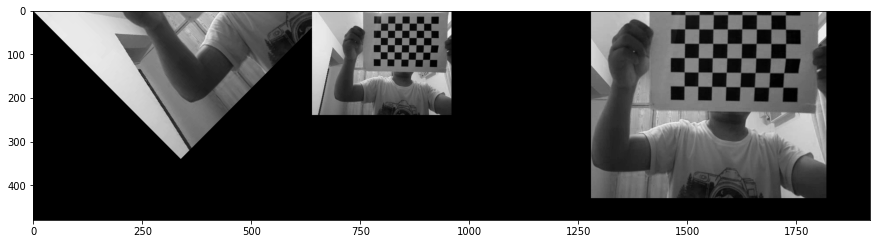

In [2]:
def getSimWarp(dx, dy, rotation, scale):
    rad = np.radians(rotation)
    M = np.array(
        [[ np.cos(rad), np.sin(rad), dy],
         [-np.sin(rad), np.cos(rad), dx]]
    )
    return M * scale

def warpImage(img, W):
    height, width = img.shape
    warped_img = np.zeros(img.shape, dtype=np.float32)
    for x in range(width):
        for y in range(height):
            new = np.matmul(W, np.array([y, x, 1]).T)
            nx, ny = int(new[1]), int(new[0])
            if(0 <= nx < width) and (0 <= ny < height):
                warped_img[y, x] = img[ny, nx]
    return warped_img

rot_45 = warpImage(img, getSimWarp(0, 0, 45, 1))
scale_2 = warpImage(img, getSimWarp(0, 0, 0, 2))
shift_100_50 = warpImage(img, getSimWarp(100, 50, 0, 1))

combined = np.concatenate((rot_45, scale_2, shift_100_50), axis=1)

plt.imshow(combined, cmap='gray')
plt.show()

The transformations we have made here are good, but not very helpful in our case. What we need is a function that extracts a patch from the image and warps it according to our function, but we can't do that with the functions we have just written. If we extract the patch first and warp it afterwards, we will have a mostly black image. If we first warp and then extract the patch, the warping is not applied correctly. So we need to write yet another function extracts a patch at position (u,v), applies the Warping with (u,v) as an origin and returns the patch. 

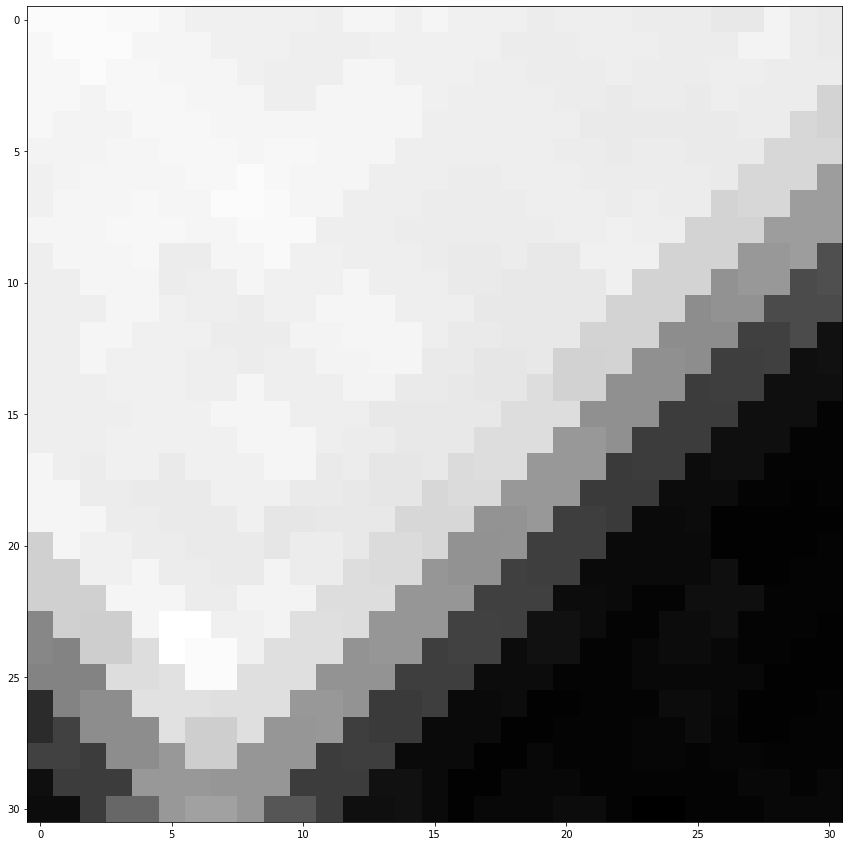

In [3]:
def getWarpedPatch(img, W, u, v, r):
    patch = np.zeros(shape=(2*r+1, 2*r+1), dtype=np.float32)
    height, width = img.shape
    
    for x in range(2*r+1):
        for y in range(2*r+1):
            new = np.matmul(W, np.array([y-r, x-r, 1]).T)
            nx, ny = u+int(new[1]), v+int(new[0])
            if(0 <= nx < width) and (0 <= ny < height):
                patch[y, x] = img[ny, nx]
    return patch

patch = getWarpedPatch(img, getSimWarp(100, 50, 45, 0.5), 500, 200, 15)
plt.imshow(patch, cmap='gray')
plt.show()

## Block-based method
Let's implement a brute-force, block-based method in finding the transformation between two patches. However, we will only deal with simple translation here since otherwise our brute forcer will take too long. 

Best fit at (u, v) = (-15, -10). Should be (u, v) = (-15, -10)


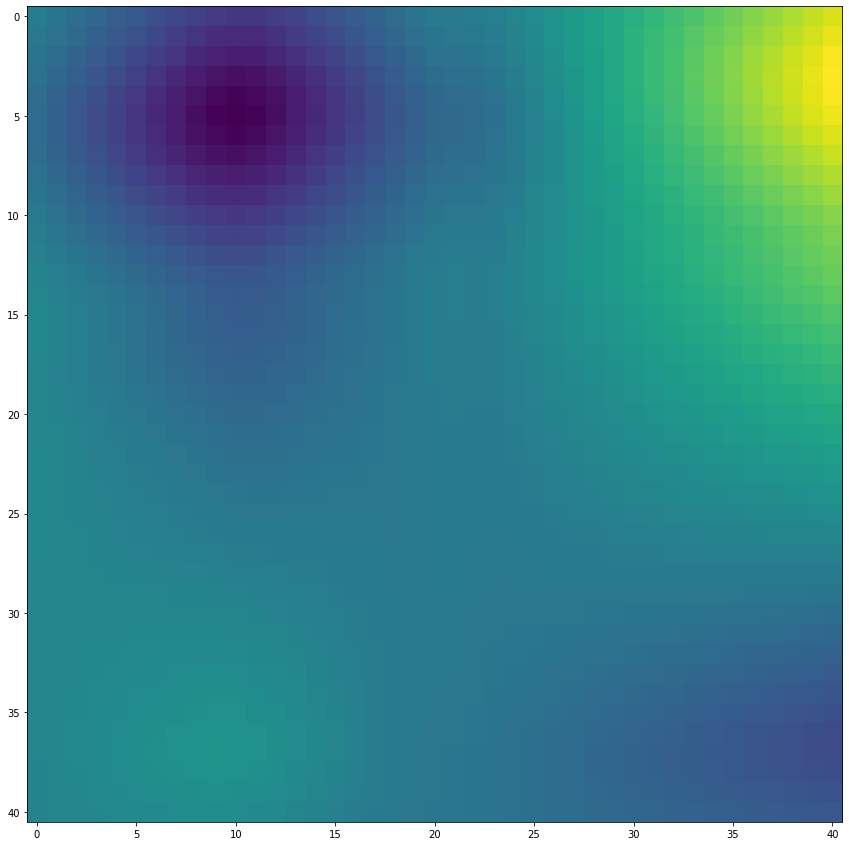

In [4]:
def blockSearch(ref_img, run_img, u, v, patch_radius, search_radius):
    W_template = getSimWarp(0, 0, 0, 1)
    template = getWarpedPatch(ref_img, W_template, u, v, patch_radius)
    
    ssds = np.zeros(shape=(2*search_radius+1, 2*search_radius+1), dtype=np.float32)
    min_ssd = 10000
    min_u, min_v = 0, 0
    for p5 in range(-search_radius, search_radius+1):
        for p6 in range(-search_radius, search_radius+1):
            W0 = getSimWarp(p5, p6, 0, 1)
            search = getWarpedPatch(run_img, W0, u, v, patch_radius)
            dist = search - template;
            ssd = np.sum(dist.flatten() ** 2)
            ssds[p5+search_radius, p6+search_radius] = ssd
            if ssd < min_ssd:
                min_ssd = ssd
                min_u, min_v = p5+search_radius, p6+search_radius
    return ssds, min_ssd, min_u-search_radius, min_v-search_radius

shift_15_10 = warpImage(img, getSimWarp(15, 10, 0, 1))
ssds, min_ssd, min_u, min_v = blockSearch(img, shift_15_10, u=550, v=200, patch_radius=15, search_radius=20)
print(f"Best fit at (u, v) = ({min_u}, {min_v}). Should be (u, v) = (-15, -10)")
plt.imshow(ssds)
plt.show()

## KLT
